# Exploration for corpus stats and initial topic modeling experiments

In [2]:
from pathlib import Path
import string

import pandas as pd
import seaborn as sns


In [3]:
# Reusable functions 
def get_stop_list(stop_file):
    """Returns a set of stop words from file where
    they're one per line
    :param stop_file: Path object
    """
    text = stop_file.read_text(encoding="utf-8")
    stops = set([s.strip() for s in text.split("\n")])
    if '' in stops:
        stops.remove('')
    return stops

def get_stopped_text(text, stop_set):
    """Remove stop words from text after splitting
    on whitespace
    :param text: str
    :param stop_set: set of str
    """
    clean_text = text.translate(str.maketrans('','', string.punctuation))
    return " ".join([s for s in clean_text.split() if s not in stop_set])

def get_num_tokens(text):
    """Returns the number of tokens after splitting on whitespace.
    :param text: str
    """
    return len(text.split())


# Read corpus

In [4]:
CORPUS_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels')
DOCS_TSV = CORPUS_DIR / 'russian_novels.tsv'
STOP_LIST = CORPUS_DIR / 'russian_novels_stopped.txt'


In [5]:
stops = get_stop_list(STOP_LIST)
print("Number of words pruned from vocab:")
len(stops)

Number of words pruned from vocab:


245783

TODO: Look at sums of word types dropped 

In [6]:
corpus = pd.read_csv(DOCS_TSV, sep='\t', encoding='utf-8', names=['doc_id', 'author', 'text'], index_col=0)
corpus['author'] = corpus['author'].astype('category')

In [7]:
print(corpus.columns)
print(corpus.index)
corpus.head()

Index(['author', 'text'], dtype='object')
Index(['Turgenev_Rudin_0', 'Turgenev_Rudin_1', 'Turgenev_Rudin_2',
       'Turgenev_Rudin_3', 'Turgenev_Rudin_4', 'Turgenev_Rudin_5',
       'Turgenev_Rudin_6', 'Turgenev_Rudin_7', 'Turgenev_Rudin_8',
       'Turgenev_Rudin_9',
       ...
       'Bulgakov_Diavoliada_11', 'Bulgakov_Diavoliada_12',
       'Bulgakov_Diavoliada_13', 'Bulgakov_Diavoliada_14',
       'Bulgakov_Diavoliada_15', 'Bulgakov_Diavoliada_16',
       'Bulgakov_Diavoliada_17', 'Bulgakov_Diavoliada_18',
       'Bulgakov_Diavoliada_19', 'Bulgakov_Diavoliada_20'],
      dtype='object', name='doc_id', length=10967)


,author,text
doc_id,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан..."
Turgenev_Rudin_2,Turgenev,Александра Павловна отправилась тихонько назад...
Turgenev_Rudin_3,Turgenev,"-- Вас Дарья Михайловна ко мне прислала, говор..."
Turgenev_Rudin_4,Turgenev,"-- Ступай, барин, право... Константин Диомидыч..."


In [8]:
corpus['stopped_text'] = corpus['text'].apply(get_stopped_text, args=(stops,))
corpus.head(2)

,author,text,stopped_text
doc_id,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,I Было тихое летнее утро Солнце довольно высок...
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",Ну прощай Матрена проговорила Александра Павло...


In [9]:
corpus['doc_length'] = corpus['text'].apply(get_num_tokens)
corpus['stopped_length'] = corpus['stopped_text'].apply(get_num_tokens)
corpus.head(2)

,author,text,stopped_text,doc_length,stopped_length
doc_id,,,,,
Turgenev_Rudin_0,Turgenev,I Было тихое летнее утро. Солнце уже довольно ...,I Было тихое летнее утро Солнце довольно высок...,510,416
Turgenev_Rudin_1,Turgenev,"-- Ну, прощай, Матрена! -- проговорила Алексан...",Ну прощай Матрена проговорила Александра Павло...,507,382


# Corpus statistics
## Original (unpruned) corpus
Corpus is https://github.com/ginic/RussianNovels/tree/cleanups


In [10]:
print("Total documents:", len(corpus))
print("Document length statistics:")
print("Total tokens:", corpus['doc_length'].sum())
corpus['doc_length'].describe()

Total documents: 10967
Document length statistics:
Total tokens: 6665695


count    10967.000000
mean       607.795660
std        308.318168
min          2.000000
25%        505.000000
50%        513.000000
75%        563.000000
max       6819.000000
Name: doc_length, dtype: float64

In [11]:
author_groupby = corpus.groupby('author')

In [12]:
docs_by_author = author_groupby['text'].size().reset_index(name="doc_count").sort_values('doc_count', ascending=False)
docs_by_author['doc_count'].describe()

count      24.000000
mean      456.958333
std       492.460325
min        15.000000
25%       130.500000
50%       224.000000
75%       598.250000
max      1621.000000
Name: doc_count, dtype: float64

In [13]:
print("Most prolific by docs")
display(docs_by_author.head())
print("Least prolific by docs")
display(docs_by_author.tail())

Most prolific by docs


,author,doc_count
17,Tolstoi,1621
8,Gorky,1570
15,Sholokhov,1301
11,Nabokov,1228
3,Dostoyevsky,660


Least prolific by docs


,author,doc_count
14,SKhvoshchinskaya,77
22,Zhukova,56
5,Gan,52
20,Volkonskaya,25
23,Zinovieva-Annibal,15


<AxesSubplot:xlabel='doc_count', ylabel='author'>

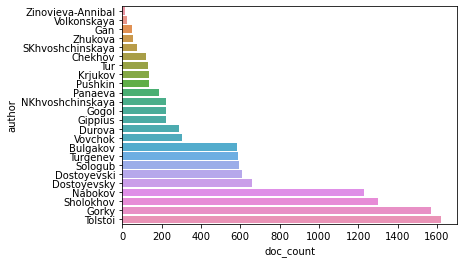

In [14]:
sns.barplot(data=docs_by_author, y='author', x='doc_count', order=docs_by_author.sort_values('doc_count').author)

In [15]:
tokens_by_author = author_groupby['doc_length'].sum().reset_index(name='token_count').sort_values('token_count', ascending=False)
tokens_by_author['token_count'].describe()

count    2.400000e+01
mean     2.777373e+05
std      2.966164e+05
min      7.340000e+03
25%      7.484875e+04
50%      1.435800e+05
75%      3.766648e+05
max      1.019374e+06
Name: token_count, dtype: float64

In [16]:
print("Most prolific by tokens")
display(tokens_by_author.head())
print("Least prolific by tokens")
display(tokens_by_author.tail())

Most prolific by tokens


,author,token_count
11,Nabokov,1019374
17,Tolstoi,884552
8,Gorky,825258
15,Sholokhov,656213
3,Dostoyevsky,520475


Least prolific by tokens


,author,token_count
14,SKhvoshchinskaya,43943
5,Gan,37279
22,Zhukova,36146
20,Volkonskaya,13528
23,Zinovieva-Annibal,7340


<AxesSubplot:xlabel='token_count', ylabel='author'>

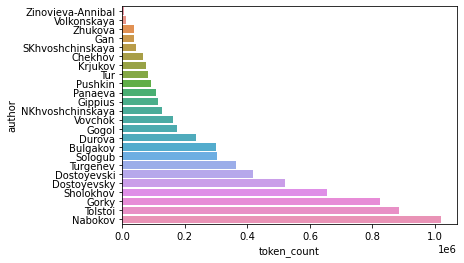

In [17]:
sns.barplot(data=tokens_by_author, y='author', x='token_count', order=tokens_by_author.sort_values('token_count').author)

TODO: Dostoyevski needs to be normalized!! 
```
~/workspace/RussianNovels/corpus$ ls Dost*
Dostoyevski_Biesy.txt        Dostoyevsky_Karamazow2.txt
Dostoyevski_Idiot.txt        Dostoyevsky_Karamazow3.txt
Dostoyevsky_BednyeLyudi.txt  Dostoyevsky_Karamazow4.txt
Dostoyevsky_Karamazow1.txt   Dostoyevsky_PrestupleniyeINakazaniye.txt
```

## Pruned corpus
Mallet corpus was pruned using the following settings:
- `MIN_TERM_FREQ := 5`: A term is pruned if it appears in less than 5 documents
 - `MIN_IDF := 1.39`: For Mallet, a given term's idf = ln(|corpus|/doc_freq), so 1.39 is 25% of corpus. Terms are pruned if they are in more than 25% of documents

Prune by running: `mallet prune --input input.mallet --output output_pruned.mallet --min-idf $(MIN_IDF) --prune-count $(MIN_TERM_FREQ)`


In [18]:
print("Document length statistics:")
print("Total tokens:", corpus['stopped_length'].sum())
corpus['stopped_length'].describe()

Document length statistics:
Total tokens: 5120706


count    10967.000000
mean       466.919486
std        237.881306
min          0.000000
25%        385.000000
50%        402.000000
75%        437.000000
max       5171.000000
Name: stopped_length, dtype: float64

In [19]:
pruned_tokens_by_author = author_groupby['stopped_length'].sum().reset_index(name='token_count_after_pruning').sort_values('token_count_after_pruning', ascending=False)
pruned_tokens_by_author['token_count_after_pruning'].describe()

count        24.000000
mean     213362.750000
std      226827.813816
min        5590.000000
25%       58317.000000
50%      108050.500000
75%      289456.500000
max      787293.000000
Name: token_count_after_pruning, dtype: float64

In [20]:
print("Most prolific by tokens after pruning")
display(pruned_tokens_by_author.head())
print("Least prolific by tokens after pruning")
display(pruned_tokens_by_author.tail())

Most prolific by tokens after pruning


,author,token_count_after_pruning
11,Nabokov,787293
17,Tolstoi,667988
8,Gorky,627103
15,Sholokhov,510528
3,Dostoyevsky,389608


Least prolific by tokens after pruning


,author,token_count_after_pruning
14,SKhvoshchinskaya,33565
5,Gan,29457
22,Zhukova,27819
20,Volkonskaya,10473
23,Zinovieva-Annibal,5590


<AxesSubplot:xlabel='token_count_after_pruning', ylabel='author'>

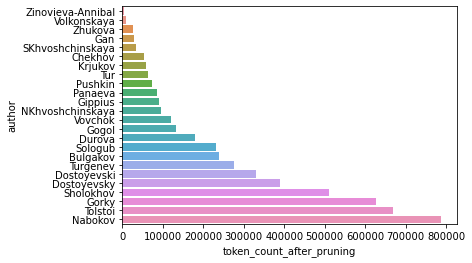

In [21]:
sns.barplot(data=pruned_tokens_by_author, y='author', x='token_count_after_pruning', order=pruned_tokens_by_author.sort_values('token_count_after_pruning').author)

TODO: Normalized token counts per document by author

# Analysis of topics
A topic model was trained on the pruned corpus with the following settings:
- `NUM_TOPICS := 100`
- `NUM_ITERS := 1000`
- `OPTIMIZE_INTERVAL := 20`
- `OPTIMIZE_BURN_IN := 50`

Mallet training command:
`mallet train-topics $(MALLET_TOPIC_FLAGS) --input input_pruned.mallet --output-state $(state) --output-model $(output_model) --output-doc-topics $(doc_topics) --output-topic-keys $(topic_keys)`

In [22]:
EXPERIMENT_DIR = Path('/home/virginia/workspace/topic-modeling-study/russian_novels/russian_novels_100topics_1000iters')
# Mallet ouput with manually added comments on topic quality
TOPIC_KEYS = EXPERIMENT_DIR / 'russian_novels_100topics_1000iters_topic_keys_with_comments.tsv'

In [23]:
topics = pd.read_csv(TOPIC_KEYS, sep='\t', encoding='utf-8', index_col=0)
topics.head()

,topic_proportion_per_doc,tokens,comment
tid,,,
0,0.01269,вера александровна любовь васильевна ольга зоя...,Names
1,0.09763,чай стакан стол вина стола вино пить выпил вод...,"Drinking – tea, cup, table, wine, vodka, coffee"
2,0.04519,самгин самгина клим самгину варвара точно чтоб...,Gorky – The Life of Klim Samgin
3,0.01990,франц марта драйер поезд вагона станции вагон ...,"Traveling and trains, but also Franz Dreyer fr..."
4,0.21084,могла говорила сама знала думала хотела говори...,Past tense feminine verbs


## Author entropy
Produced with command:
`python ~/workspace/authorless-tms/topic_author_correlation.py --input russian_novels.tsv --vocab russian_novels_pruned_vocab.txt --input-state russian_novels_100topics_1000iters/russian_novels_100topics_1000iters.gz --output russian_novels_100topics_1000iters/russian_novels_100topics_1000iters_author_correlation.tsv`


In [24]:
AUTHOR_CORRELS = EXPERIMENT_DIR /'russian_novels_100topics_1000iters_author_correlation.tsv'

In [25]:
author_correls = pd.read_csv(AUTHOR_CORRELS, sep='\t', encoding='utf-8', index_col=0)
author_correls.head()

,Author Entropy,Minus Major Author,Balanced Authors
Topic,,,
0,1.713103,0.172548,0.212536
1,2.581627,0.011270,0.065647
2,0.206651,0.428270,0.443944
3,1.347237,0.198656,0.296218
4,2.496419,0.008288,0.024083


<AxesSubplot:xlabel='Author Entropy', ylabel='Count'>

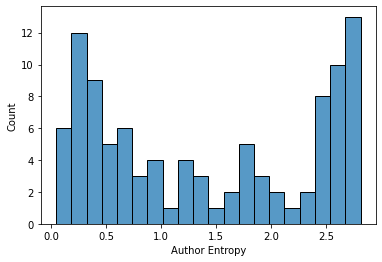

In [40]:
sns.histplot(data=author_correls['Author Entropy'], bins=20)

<AxesSubplot:xlabel='Minus Major Author', ylabel='Count'>

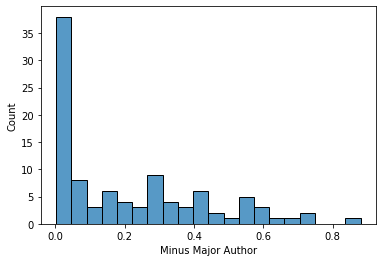

In [41]:
sns.histplot(data=author_correls['Minus Major Author'], bins=20)

<AxesSubplot:xlabel='Balanced Authors', ylabel='Count'>

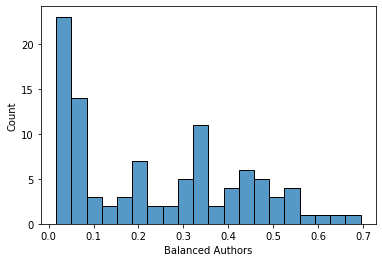

In [42]:
sns.histplot(data=author_correls['Balanced Authors'], bins=20)

In [43]:
#cols = author_correls.columns.values.tolist()
#stacked_entropies = author_correls[cols].stack().reset_index()
#stacked_entropies.rename(columns = {"level_1":"method", 0:"value"}, inplace=True)
#stacked_entropies.head()
#grid = sns.displot(data=stacked_entropies, x="value", col="method", height=10)
# TODO minus major author and balanced authors to their own plot, share x axes turned off, change bin size


In [27]:
topics_with_entropy = pd.merge(topics, author_correls, left_index=True, right_index=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
topics_with_entropy.sort_values("Author Entropy").head(100)


,topic_proportion_per_doc,tokens,comment,Author Entropy,Minus Major Author,Balanced Authors
tid,,,,,,
64,0.00204,мнe лида нeт ардалион феликс герман вeдь себe мое всe тебe гдe тeм мной моя человeк нeсколько дeло помню моей,Pronouns,0.042837,0.879995,0.694735
89,0.00759,пнин пнина гаген тимофей пнину профессор своего миссис доктор клементс шато снова джоун свой бетти друг джоан д-р лиза которая,Nabokov – Pnin,0.103448,0.733001,0.628492
36,0.00530,нежданов марианна соломин паклин сипягин маркелов нежданова калломейцев валентина машурина михайловна нежданову промолвил маркелова сипягина соломина татьяна начал алексей остродумов,Names,0.134090,0.721145,0.622843
81,0.01087,ван ада вана люсетта марина ады демон вану the аде аду мадемуазель вин ларивьер адой бланш демона моя миг ардис,Nabokov – Ada,0.146696,0.664453,0.578167
91,0.00518,граф евстафий чтоб астольда графа евстафия кауни тодеуш астольды этаго графиня нибудь своего однакож клутницкий гедвига надобно торгайло торгайлы котораго,'Count' and 'Countess' ?,0.156809,0.619591,0.542143
80,0.02326,клим лидия макаров клима лютов климу варавка иноков самгин спивак алина туробоев лидии дронов чтоб пред мать макарова диомидов дмитрий,Gorky – The Life of Klim Samgin,0.166438,0.544568,0.524330
24,0.01706,давыдов нагульнов макар разметнов давыдова факт товарищ колхоза колхоз почему давыдову лушка кондрат любишкин председатель нагульнова хлеб макара быков партии,collective farming – Sholokov,0.191821,0.541757,0.513858
40,0.00691,ортруда королева танкред афра всё меччио королевы ортруды танкреда астольф лорена имогена виктор ещё принца принц филиппо ортруде ортруду спросила,?,0.192856,0.588590,0.523801
2,0.04519,самгин самгина клим самгину варвара точно чтоб марина подумал пред снова дронов затем иванович тагильский вообще чорт безбедов кутузов сердито,Gorky – The Life of Klim Samgin,0.206651,0.428270,0.443944


## Morphological analysis of topics
Questions to answer:
- Which topics have multiple words with the same lemma? What about morphological variation on proper names?
- Which lemmas appear frequently across different topics? 
- Which topics contain many words of the same morphological type (e.g. past tense feminine sg verbs)? What types?